In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [88]:
train_path = '../input/titanic/train.csv'
test_path = '../input/titanic/test.csv'
submission_path = '../input/titanic/gender_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_submission = pd.read_csv(submission_path)

In [89]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [90]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

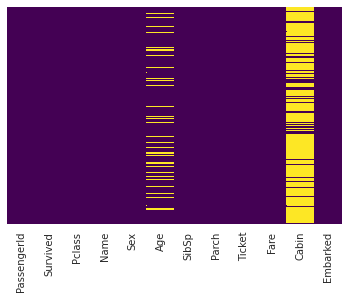

In [91]:
#visualizing nan/null values
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [92]:
features_having_nan = [(cols, df_train[cols].dtype) for cols in df_train.columns if df_train[cols].isnull().sum()>1]
features_having_nan

[('Age', dtype('float64')), ('Cabin', dtype('O')), ('Embarked', dtype('O'))]

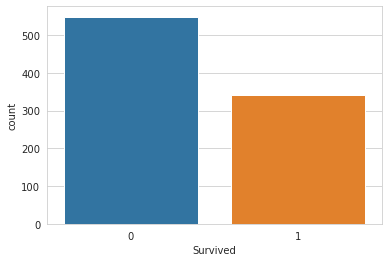

In [93]:
#visualizing how many survived and how many not survived
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=df_train)

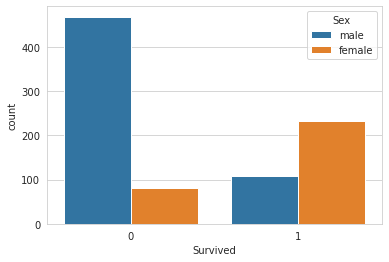

In [94]:
#visualizing how many survived and how many not survived based on sex
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex', data=df_train)

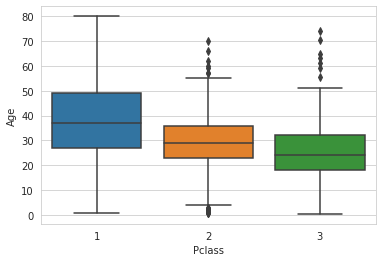

In [95]:
#handling age attribute 
sns.boxplot(x='Pclass', y='Age', data=df_train)

In [96]:
#imputing age based on Pclass
def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    if pd.isnull(age):
        if pclass == 1:
            return 38
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

df_train['Age'] = df_train[['Age', 'Pclass']].apply(impute_age, axis=1)

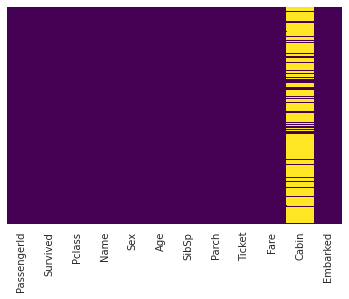

In [97]:
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [98]:
#as cabin is having a lot of nan values, therefore droping it
df_train.drop(['Cabin'], axis=1, inplace=True)

#for test set
df_test.drop(['Cabin'], axis=1, inplace=True) # 90% nan values, so no use of this attribute

In [99]:
#one hot encoding categorical attributes
sex = pd.get_dummies(df_train['Sex'], drop_first=True) #dummy trap technique
Embarked = pd.get_dummies(df_train['Embarked'], drop_first=True) #dummy trap technique

#for test set
sex_test = pd.get_dummies(df_test['Sex'], drop_first=True) #dummy trap technique
Embarked_test = pd.get_dummies(df_test['Embarked'], drop_first=True) #dummy trap technique

In [100]:
df_train.drop(['Sex', 'Embarked', 'PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_test.drop(['Name', 'Sex', 'Embarked', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [101]:
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [102]:
df_train = pd.concat([df_train, sex, Embarked], axis=1)
df_test = pd.concat([df_test, sex_test, Embarked_test], axis=1)

In [103]:
y = df_train['Survived'].to_list()
X = df_train.drop('Survived', axis=1)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [104]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [105]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost

In [107]:
classifiers = [LogisticRegression(), RandomForestClassifier(n_estimators=100), xgboost.XGBClassifier()]

for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print('\nClassifier: ', clf.__class__.__name__)
    print(accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


Classifier:  LogisticRegression
0.7985074626865671
[[68 11]
 [16 39]]

Classifier:  RandomForestClassifier
0.8432835820895522
[[72  7]
 [14 41]]

Classifier:  XGBClassifier
0.8731343283582089
[[74  5]
 [12 43]]
